---
title: Lab 6 Variable Selection and Regularization
author: Sneha Narayanan
format:
    html:
        toc: true
        code-fold: true
embed-resources: true
theme: "Lumen"

---

In [121]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from numpy import mean

In [3]:
data=pd.read_csv('Hitters.csv')

In [4]:
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [6]:
data.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

### *59 Values in the 'Salary' column is missing, which is not a small percentage as the total number of obsv in our dataset is only 322.*

/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 59 rows containing non-finite values.
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 59 rows containing non-finite values.


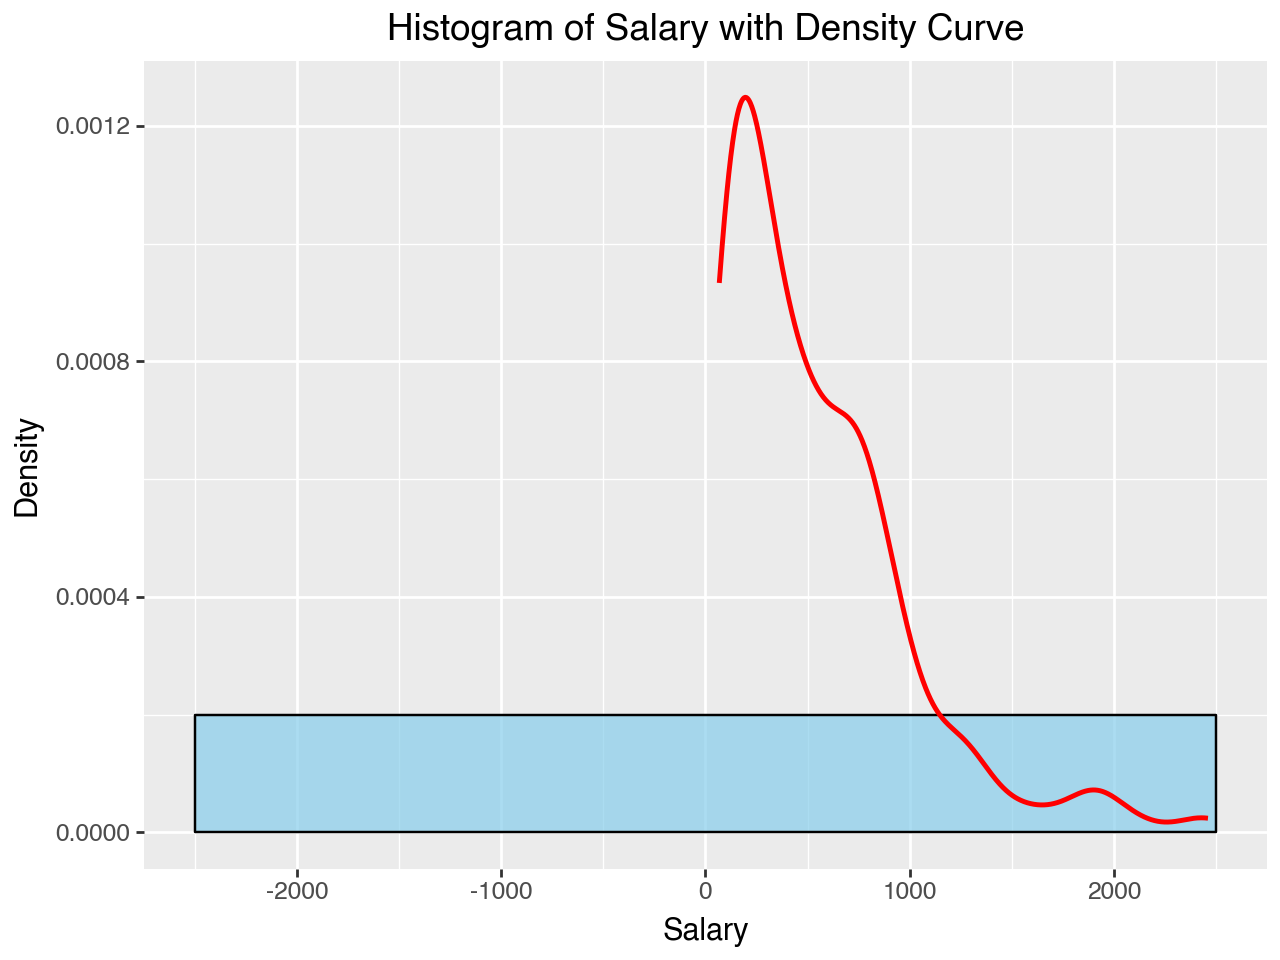

In [9]:
from plotnine import ggplot, aes, geom_histogram, geom_density, labs, theme
import pandas as pd

ggplot(data, aes(x='Salary')) + 
    geom_histogram(aes(y='..density..'), binwidth=5000, color="black", fill="skyblue", alpha=0.7) + \
    geom_density(color="red", size=1) + 
    labs(title='Histogram of Salary with Density Curve', x='Salary', y='Density') + \
    theme()

### *The above graph clearly shows that Salary is not normally distributed so we can't fill the missing values using 'mean'.For skewed data(in this case right skewed), filling the missing values with 'median' is the better option.*

In [16]:
data['Salary'].fillna(data['Salary'].median(), inplace=True)

In [17]:
data.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

# Part I: Different Model Specs

## A. Regression without regularization

### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [73]:
X = data.drop(columns='Salary')
y = data['Salary']

In [186]:
def create_pipeline(regressor):
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    return pipeline

In [13]:
regressor = LinearRegression()

In [14]:
pipeline = create_pipeline(regressor)

### 2.Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [173]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['CRuns', 'Hits', 'CRBI',
                                                   'Walks', 'AtBat']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Division'])])),
                ('regressor', LinearRegression())])

In [25]:
coefficients = pipeline.named_steps['regressor'].coef_

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

coef_series = pd.Series(coefficients, index=feature_names)
important_features = coef_series.sort_values(ascending=False)
important_features

num__CRuns          397.451883
num__Hits           279.118329
num__CRBI           194.437401
num__CHits          143.681651
num__Walks          114.292821
num__PutOuts         60.625723
num__Assists         55.114204
cat__Division_E      54.839885
num__HmRun           39.816538
cat__League_N        17.823668
cat__NewLeague_A      4.573315
num__RBI             -3.626005
cat__NewLeague_N     -4.573315
num__Runs           -13.050010
cat__League_A       -17.823668
num__Errors         -27.152020
num__CHmRun         -36.346190
num__Years          -54.269200
cat__Division_W     -54.839885
num__CWalks        -169.496186
num__AtBat         -305.975198
num__CAtBat        -327.578532
dtype: float64

1. num__CRuns = 397.45 (Positive):
More cumulative runs significantly increase salary, reflecting the importance of consistent offensive performance.
2. num__Hits = 279.12 (Positive):
A high number of hits strongly correlates with a higher salary, indicating the value of a player's ability to get on base.
3. num__CWalks = -169.50 (Negative):
More walks reduce salary, suggesting that players with many walks but fewer hits or runs are less valued.
4. num__AtBat = -305.98 (Negative):
More at-bats without significant performance (e.g., hits or runs) negatively impact salary, possibly due to inefficiency at the plate.
5. num__CRBI = 194.44 (Positive):
Cumulative RBIs also positively impact salary, showing that driving in runs is a key factor in earning a higher salary.

### 3.Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [29]:
mse_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
mse_scores = -mse_scores

print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average MSE: {mse_scores.mean()}")
print(f"Average R²: {r2_scores.mean()}")

Cross-validated MSE scores: [ 83305.10368895 128707.59430304  82360.61468949 149753.81534333
 107973.2591496 ]
Cross-validated R2 scores: [-0.0281479   0.48245755  0.59138091  0.06527161  0.16253095]
Average MSE: 110420.07743488387
Average R²: 0.2546986222471184


## B. Ridge regression

### 1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [174]:
regressor = Ridge()

In [175]:
pipeline_ridge = create_pipeline(regressor)

In [176]:
pipeline_ridge.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('regressor', Ridge())])

In [177]:
mse_scores = cross_val_score(pipeline_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(pipeline_ridge, X, y, cv=5, scoring='r2')
mse_scores = -mse_scores

print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average MSE: {mse_scores.mean()}")
print(f"Average R²: {r2_scores.mean()}")

Cross-validated MSE scores: [ 81269.86168372 130405.60662613  81883.13875661 143223.97216438
 101020.5383511 ]
Cross-validated R2 scores: [-0.00302904  0.47562972  0.59374983  0.10602937  0.21645808]
Average MSE: 107560.62351638745
Average R²: 0.2777675926102753


### 2.Use cross-validation to tune the lambda hyperparameter.

In [65]:
param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}

In [66]:
grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
r2_scores = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='r2')

In [72]:
grid_search.fit(X, y)
r2_scores.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='r2')

In [68]:
print(f"Best alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Best cross-validated MSE: {-grid_search.best_score_}")

Best alpha: 1
Best cross-validated MSE: 107560.62351638745


In [69]:
print(f"Best alpha for R²: {r2_scores.best_params_['regressor__alpha']}")
print(f"Best cross-validated R²: {r2_scores.best_score_}")

Best alpha for R²: 100
Best cross-validated R²: 0.29722787443806875


### 3.Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

In [70]:
best_alpha = grid_search.best_params_['regressor__alpha']

regressor = Ridge(alpha=best_alpha)
pipeline_ridge = create_pipeline(regressor)
pipeline_ridge.fit(X, y)

coefficients = pipeline_ridge.named_steps['regressor'].coef_
coef_series = pd.Series(coefficients, index=feature_names)
important_features = coef_series.sort_values(ascending=False)
print(important_features)

num__CRuns          294.978926
num__Hits           252.077892
num__CHits          143.910523
num__CRBI           129.299644
num__Walks          107.529049
num__PutOuts         60.663593
cat__Division_E      56.237217
num__Assists         49.790835
num__HmRun           26.543327
cat__League_N        17.829724
num__RBI              7.461421
num__Runs             5.883310
cat__NewLeague_A      5.330031
num__CHmRun          -1.199830
cat__NewLeague_N     -5.330031
cat__League_A       -17.829724
num__Errors         -27.781695
cat__Division_W     -56.237217
num__Years          -69.435816
num__CWalks        -151.839635
num__CAtBat        -194.413456
num__AtBat         -289.653633
dtype: float64


Interpretations of a few of the most important coefficients:

1. **num__CRuns (294.98)**: A higher number of cumulative runs positively impacts salary, reflecting the value of consistent offensive performance.
2. **num__Hits (252.08)**: More hits increase salary, highlighting the importance of a player's ability to get on base.
3. **num__CHits (143.91)**: A higher number of cumulative hits also positively correlates with salary, reinforcing the importance of offensive contribution.
4. **num__CRBI (129.30)**: More cumulative RBIs increase salary, indicating the value of driving in runs.
5. **num__Walks (107.53)**: More walks slightly increase salary, showing some value in a player's ability to reach base through walks.

Negative coefficients:
- **num__CWalks (-151.84)**: An increase in walks reduces salary, suggesting players with many walks but fewer hits or runs may be less valued.
- **num__CAtBat (-194.41)**: More cumulative at-bats without significant performance (e.g., hits or runs) negatively impact salary.
- **num__AtBat (-289.65)**: More at-bats without efficient performance also reduce salary, likely due to inefficiency at the plate.

### 4.Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [71]:
mse_scores = cross_val_score(pipeline_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
print(f"Expected MSE for 1989 salaries: {mse_scores.mean()}")

Expected MSE for 1989 salaries: 107560.62351638745


### The expected mean squared error (MSE) of approximately 107,561 indicates the average squared difference between the predicted and actual salaries for 1989, reflecting the model's prediction accuracy.

## C. LASSO REGRESSION

In [83]:
regressor = Lasso(max_iter=10000, alpha=best_alpha)

In [84]:
pipeline_lasso = create_pipeline(regressor)

In [85]:
pipeline_lasso.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('regressor', Lasso(alpha=1, max_iter=10000))])

In [86]:
mse_scores = cross_val_score(pipeline_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(pipeline_lasso, X, y, cv=5, scoring='r2')
mse_scores = -mse_scores

print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average MSE: {mse_scores.mean()}")
print(f"Average R²: {r2_scores.mean()}")

Cross-validated MSE scores: [ 79838.95993799 131410.42426261  83256.65850057 144497.76049797
  99891.88405682]
Cross-validated R2 scores: [0.01463109 0.47158928 0.58693533 0.09807868 0.22521222]
Average MSE: 107779.13745119298
Average R²: 0.27928931922979


In [87]:
param_grid = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline_lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print(f"Best alpha: {grid_search.best_params_['regressor__alpha']}")
print(f"Best cross-validated MSE: {-grid_search.best_score_}")

Best alpha: 1
Best cross-validated MSE: 107779.13745119298


### 3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

In [88]:
best_alpha = grid_search.best_params_['regressor__alpha']
regressor = Lasso(alpha=best_alpha)

pipeline_lasso = create_pipeline(regressor)
pipeline_lasso.fit(X, y)

coefficients = pipeline_lasso.named_steps['regressor'].coef_
feature_names = pipeline_lasso.named_steps['preprocessor'].get_feature_names_out()

coef_series = pd.Series(coefficients, index=feature_names)
important_features = coef_series.sort_values(ascending=False)
print("Most important coefficients:")
print(important_features.head()) 

Most important coefficients:
num__CRuns         315.247989
num__Hits          274.151106
num__CRBI          118.671738
cat__Division_E    110.126498
num__Walks         107.034474
dtype: float64


- **num__CRuns (315.25)**: The number of career runs has a strong positive impact on salary, meaning more runs are associated with higher salaries.
- **num__Hits (274.15)**: More career hits also positively affect salary, suggesting that higher hit counts are linked to higher salaries.
- **num__CRBI (118.67)**: Career RBIs (Runs Batted In) positively influence salary, with more RBIs correlated to higher salaries.
- **cat__Division_E (110.13)**: Playing in the 'East' division has a positive effect on salary compared to other divisions.
- **num__Walks (107.03)**: More career walks are associated with higher salaries, indicating a positive relationship between discipline at the plate and salary.

### 4.Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [90]:
mse_scores = cross_val_score(pipeline_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -mse_scores 

print(f"Expected MSE for 1989 salarie using lasso regression is: {mse_scores.mean()}")

Expected MSE for 1989 salarie using lasso regression is: 107788.05472624791


/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.126e+03, tolerance: 4.831e+03


The expected Mean Squared Error (MSE) for predicting 1989 salaries using Lasso regression is approximately 107,788.05. This means that, on average, the model's predictions deviate from the actual values by about 107,788 salary units squared. 

## D. ELASTIC NET

In [100]:
regressor = ElasticNet(max_iter=10000)

In [101]:
pipeline_elastic = create_pipeline(regressor)

In [102]:
pipeline_elastic.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('regressor', ElasticNet(max_iter=10000))])

In [104]:
mse_scores = cross_val_score(pipeline_elastic, X, y, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(pipeline_elastic, X, y, cv=5, scoring='r2')
mse_scores = -mse_scores

print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average MSE: {mse_scores.mean()}")
print(f"Average R²: {r2_scores.mean()}")

Cross-validated MSE scores: [ 60792.18200484 156506.4653688   99970.76809047 149768.88992782
  89878.35981522]
Cross-validated R2 scores: [0.24970558 0.3706763  0.50401093 0.06517752 0.30287975]
Average MSE: 111383.33304142898
Average R²: 0.29849001709326684


In [105]:
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],  
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(pipeline_elastic, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                                       ('regressor',
                                        ElasticNet(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
                         'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]},
             scoring='neg_mean_squared_error')

In [106]:
print(f"Best hyperparameters: {grid_search.best_params_}")

mse_scores = -grid_search.best_score_
r2_scores = grid_search.best_estimator_.score(X, y)

Best hyperparameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1}


In [107]:
print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average MSE: {mse_scores}")
print(f"Average R²: {r2_scores}")

Cross-validated MSE scores: 107141.43207914094
Cross-validated R2 scores: 0.4573187277332459
Average MSE: 107141.43207914094
Average R²: 0.4573187277332459


In [108]:
best_pipeline = grid_search.best_estimator_

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
y_pred = best_pipeline.predict(X_train)  
mse_1989 = mean_squared_error(y_train, y_pred) 

print(f"Expected MSE for 1989 salaries: {mse_1989}")

coefficients = best_pipeline.named_steps['regressor'].coef_
print(f"Most important coefficients: {coefficients}")

Expected MSE for 1989 salaries: 88133.14645081323
Most important coefficients: [-251.14613736  210.01562617   15.54895053   22.59427343   15.57263602
   97.20927027  -77.18732588 -100.68328846  133.2325416    13.97706339
  215.28171388   97.6375168  -128.74275934   60.29619432   43.78882569
  -28.41943846  -17.57213836   17.57213428   57.29091118  -57.29092058
    5.31412752   -5.3141309 ]


*CRuns and Hits* are important predictors of salary, but with opposite directions: more runs decrease salary, while more hits increase it.

*Walks and Division_E* also play significant roles, with more walks and being in Division E leading to higher salaries.

The expected Mean Squared Error (MSE) for predicting 1989 salaries using this ElasticNet model is 88,133.15. This suggests that, on average, the model's predictions for salaries will deviate from the actual values by about 88,133 squared units, which provides a sense of the model's error or accuracy in predicting salaries

# Part II. Variable Selection

## Based on the above results, decide on:

### Which numeric variable is most important.

CRuns: Based on the coefficient interpretation in the Linear Regression and Ridge,Lasso and Elasti Net models, CRuns (Cumulative Runs) stands out as the most important numeric variable for predicting salary. A higher number of career runs positively correlates with a higher salary.

### Top Five Most Important Numeric Variables:

1. CRuns: A higher number of runs significantly increases salary.
2. Hits: More hits are strongly associated with higher salary, reflecting offensive contributions.
3. CRBI (Career RBIs): Similar to hits, RBIs positively affect salary, emphasizing the value of driving in runs.
4. Walks: While less important than other variables, more career walks are correlated with a higher salary.
5. AtBat: Though it negatively impacts salary in some models, it is still a significant predictor to consider.

### Categorical Variable

### Most Important Categorical Variable:

Division_E: The 'East' division positively impacts salary, as shown in the Lasso and ElasticNet models, making it the most important categorical variable.

### For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

In [145]:
X = data.drop(columns=['Salary'])
y = data['Salary']

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [202]:
pipeline_linear_best_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])  
    ])),
    ('regressor', LinearRegression())
])

ridge_pipeline_best_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', Ridge(alpha=1.0))
])

lasso_pipeline_best_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', Lasso(alpha=0.1))
])

elasticnet_pipeline_best_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

### Feature Set 2: Top 5 Numeric Variables (CRuns, Hits, CRBI, Walks, AtBat)

In [203]:

pipeline_linear_top5_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', LinearRegression())
])


ridge_pipeline_top5_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', Ridge(alpha=1.0))
])

lasso_pipeline_top5_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', Lasso(alpha=0.1))
])

elasticnet_pipeline_top5_numeric = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

### Feature Set 3: Top 5 Numeric Variables + Interactions with Categorical Variable (Division_E)

In [204]:
pipeline_linear_interaction = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(interaction_only=True, include_bias=False))
        ]), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', LinearRegression())
])

ridge_pipeline_interaction = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(interaction_only=True, include_bias=False))
        ]), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', Ridge(alpha=1.0))
])

lasso_pipeline_interaction = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(interaction_only=True, include_bias=False))
        ]), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', Lasso(alpha=0.1))
])

elasticnet_pipeline_interaction = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(interaction_only=True, include_bias=False))
        ]), ['CRuns', 'Hits', 'CRBI', 'Walks', 'AtBat']),
        ('cat', OneHotEncoder(drop='first'), ['Division'])
    ])),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

In [205]:
mse_linear_best_numeric = evaluate_model(pipeline_linear_best_numeric, X_train, y_train, X_test, y_test)
mse_ridge_best_numeric = evaluate_model(ridge_pipeline_best_numeric, X_train, y_train, X_test, y_test)
mse_lasso_best_numeric = evaluate_model(lasso_pipeline_best_numeric, X_train, y_train, X_test, y_test)
mse_elasticnet_best_numeric = evaluate_model(elasticnet_pipeline_best_numeric, X_train, y_train, X_test, y_test)

mse_linear_top5_numeric = evaluate_model(pipeline_linear_top5_numeric, X_train, y_train, X_test, y_test)
mse_ridge_top5_numeric = evaluate_model(ridge_pipeline_top5_numeric, X_train, y_train, X_test, y_test)
mse_lasso_top5_numeric = evaluate_model(lasso_pipeline_top5_numeric, X_train, y_train, X_test, y_test)
mse_elasticnet_top5_numeric = evaluate_model(elasticnet_pipeline_top5_numeric, X_train, y_train, X_test, y_test)

mse_linear_interaction = evaluate_model(pipeline_linear_interaction, X_train, y_train, X_test, y_test)
mse_ridge_interaction = evaluate_model(ridge_pipeline_interaction, X_train, y_train, X_test, y_test)
mse_lasso_interaction = evaluate_model(lasso_pipeline_interaction, X_train, y_train, X_test, y_test)
mse_elasticnet_interaction = evaluate_model(elasticnet_pipeline_interaction, X_train, y_train, X_test, y_test)

print("MSE for Linear Regression (Best Numeric Variable):", mse_linear_best_numeric)
print("MSE for Ridge Regression (Best Numeric Variable):", mse_ridge_best_numeric)
print("MSE for Lasso Regression (Best Numeric Variable):", mse_lasso_best_numeric)
print("MSE for ElasticNet Regression (Best Numeric Variable):", mse_elasticnet_best_numeric)

print("\nMSE for Linear Regression (Top 5 Numeric Variables):", mse_linear_top5_numeric)
print("MSE for Ridge Regression (Top 5 Numeric Variables):", mse_ridge_top5_numeric)
print("MSE for Lasso Regression (Top 5 Numeric Variables):", mse_lasso_top5_numeric)
print("MSE for ElasticNet Regression (Top 5 Numeric Variables):", mse_elasticnet_top5_numeric)

print("\nMSE for Linear Regression (Top 5 Numeric + Interaction):", mse_linear_interaction)
print("MSE for Ridge Regression (Top 5 Numeric + Interaction):", mse_ridge_interaction)
print("MSE for Lasso Regression (Top 5 Numeric + Interaction):", mse_lasso_interaction)
print("MSE for ElasticNet Regression (Top 5 Numeric + Interaction):", mse_elasticnet_interaction)

MSE for Linear Regression (Best Numeric Variable): 143112.04567871965
MSE for Ridge Regression (Best Numeric Variable): 143218.96112741498
MSE for Lasso Regression (Best Numeric Variable): 143133.27080017357
MSE for ElasticNet Regression (Best Numeric Variable): 144484.07861273907

MSE for Linear Regression (Top 5 Numeric Variables): 121715.84111671448
MSE for Ridge Regression (Top 5 Numeric Variables): 120877.2581906195
MSE for Lasso Regression (Top 5 Numeric Variables): 121547.83110217487
MSE for ElasticNet Regression (Top 5 Numeric Variables): 119418.35133765684

MSE for Linear Regression (Top 5 Numeric + Interaction): 91318.75090472851
MSE for Ridge Regression (Top 5 Numeric + Interaction): 99672.47722430246
MSE for Lasso Regression (Top 5 Numeric + Interaction): 93039.03270168419
MSE for ElasticNet Regression (Top 5 Numeric + Interaction): 90517.71413685768


/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.669e+05, tolerance: 4.133e+03


In [206]:
param_grid_ridge = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

param_grid_lasso = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

param_grid_elasticnet = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]
}

In [207]:
grid_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_lasso = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_elasticnet = GridSearchCV(elasticnet_pipeline, param_grid_elasticnet, cv=5, scoring='neg_mean_squared_error')

In [208]:
grid_ridge.fit(X_train, y_train)
grid_lasso.fit(X_train, y_train)
grid_elasticnet.fit(X_train, y_train)

/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.705e+05, tolerance: 3.109e+03
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.612e+05, tolerance: 3.219e+03
/Users/snehanarayanan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.480e+05, tolerance: 3.319e+03
/Users/snehanarayan

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True))]),
                                                                         ['CRuns',
                                                                          'Hits',
                                                                          'CRBI',
                                                                          'Walks',
                                                                          'AtBat']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Division'])])),
                                       ('regressor', ElasticNet(alpha=0.1))]),
             param_grid={'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
                         'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]},
             scoring='neg_mean_squared_error')

In [209]:
best_ridge_model = grid_ridge.best_estimator_
best_lasso_model = grid_lasso.best_estimator_
best_elasticnet_model = grid_elasticnet.best_estimator_

In [210]:
y_pred_ridge = best_ridge_model.predict(X_test)
y_pred_lasso = best_lasso_model.predict(X_test)
y_pred_elasticnet = best_elasticnet_model.predict(X_test)

In [211]:
mse_ridge_best = mean_squared_error(y_test, y_pred_ridge)
mse_lasso_best = mean_squared_error(y_test, y_pred_lasso)
mse_elasticnet_best = mean_squared_error(y_test, y_pred_elasticnet)

In [212]:
print(f"MSE for Best Ridge Model: {mse_ridge_best}")
print(f"MSE for Best Lasso Model: {mse_lasso_best}")
print(f"MSE for Best ElasticNet Model: {mse_elasticnet_best}")

MSE for Best Ridge Model: 92041.38320305958
MSE for Best Lasso Model: 88083.38945770162
MSE for Best ElasticNet Model: 87609.24943403693


In [213]:
best_lasso_alpha = grid_lasso.best_params_['regressor__alpha']
best_lasso_alpha

10.0

### Even after fine-tuning the regularization parameters (alpha and lambda), the ElasticNet model performs the best, with the lowest Mean Squared Error (MSE) of 87,609.25, compared to the Ridge model (92,041.38) and the Lasso model (88,083.39).

# Part III. Discussion

## A. Ridge
### Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

> When comparing the coefficients of the Ridge Regression model with the Ordinary Linear Regression (OLR) model, we observe that Ridge Regression tends to shrink the coefficients of the variables, especially for those with higher magnitudes, such as num__AtBat, num__CAtBat, and num__CWalks.

> It makes sense because, in datasets with highly correlated features, ordinary linear regression may assign disproportionately large coefficients, leading to unstable predictions and overfitting. Ridge regression mitigates this by shrinking the coefficients, reducing model complexity and improving generalization. This regularization helps prevent overfitting, especially when there are many features, while still allowing the model to fit the data reasonably well.

### B. LASSO 

### Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

### Lasso Model Comparison:

- **Lambda Results**: In Part I, the best alpha was `1.0` (manually selected), while in Part III, the grid search found the best alpha to be `10.0`.
- **Reasoning**: The grid search explores a range of alpha values and selects the one that minimizes MSE. Part I's alpha might not have been the optimal choice, while Part III's grid search determined that a stronger regularization (alpha = 10.0) better balances bias and variance.
- **MSE Comparison**: Part I’s MSE was `107779.14`, whereas Part III’s MSE with the best alpha (`10.0`) is `88083.39`. The lower MSE in Part III reflects improved model performance after finding the optimal regularization strength through grid search.

## C. Elastic Net
### Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

### MSE Comparison:
- **Ridge**: 107560.62
- **Lasso**: 107788.05
- **Elastic Net**: 88133.15

### Why Elastic Net "Wins":
Elastic Net combines **Lasso** (feature selection) and **Ridge** (handles correlation), resulting in the best performance with the lowest MSE. 

- **Ridge** performs well but doesn’t eliminate irrelevant features, leading to a higher MSE than Elastic Net.
- **Lasso** struggles with correlated features, increasing MSE.

Elastic Net balances both, making it more effective.

# Part IV: Final Model

### Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [184]:
X = data.drop(columns='Salary')
y = data['Salary']

In [190]:
regressor = ElasticNet(max_iter=10000)

pipeline = create_pipeline(regressor)

param_grid_elasticnet = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]
}

In [191]:
grid_search = GridSearchCV(pipeline, param_grid_elasticnet, cv=5, n_jobs=-1, verbose=1)

In [192]:
grid_search.fit(X,y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                                       ('regressor',
                                        ElasticNet(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
                         'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]},
             verbose=1)

In [193]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X)

In [194]:
mse = mean_squared_error(y, y_pred)

In [195]:
print(f"Best ElasticNet Parameters: {best_params}")
print(f"Final MSE on Full Dataset: {mse}")

Best ElasticNet Parameters: {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.1}
Final MSE on Full Dataset: 105030.45297738345


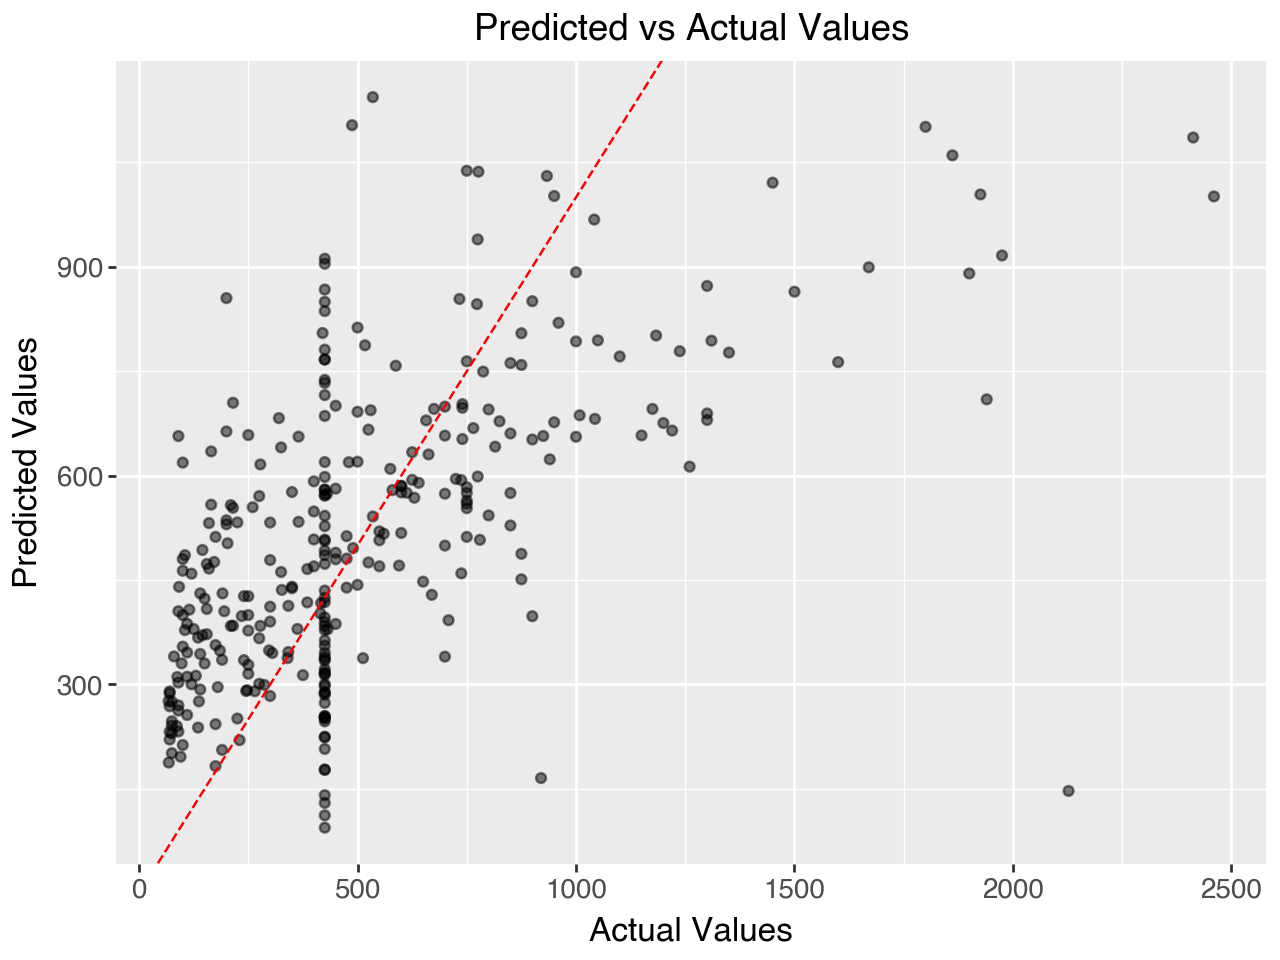

In [196]:
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme, element_text
import pandas as pd

df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

plot = (
    ggplot(df, aes(x='Actual', y='Predicted')) +
    geom_point(alpha=0.5) +  
    geom_abline(slope=1, intercept=0, color='red', linetype='dashed') +  # Line y = x
    labs(title="Predicted vs Actual Values", x="Actual Values", y="Predicted Values") +
    theme(axis_title=element_text(size=12), axis_text=element_text(size=10))
)

plot.show()

> The general trend suggests a positive correlation between predicted and actual values. This means that as the actual values increase, the predicted values also tend to increase.

> Scattered Points: The points are relatively scattered, indicating some degree of variability in the predictions. This is common in regression models, especially when dealing with complex datasets.

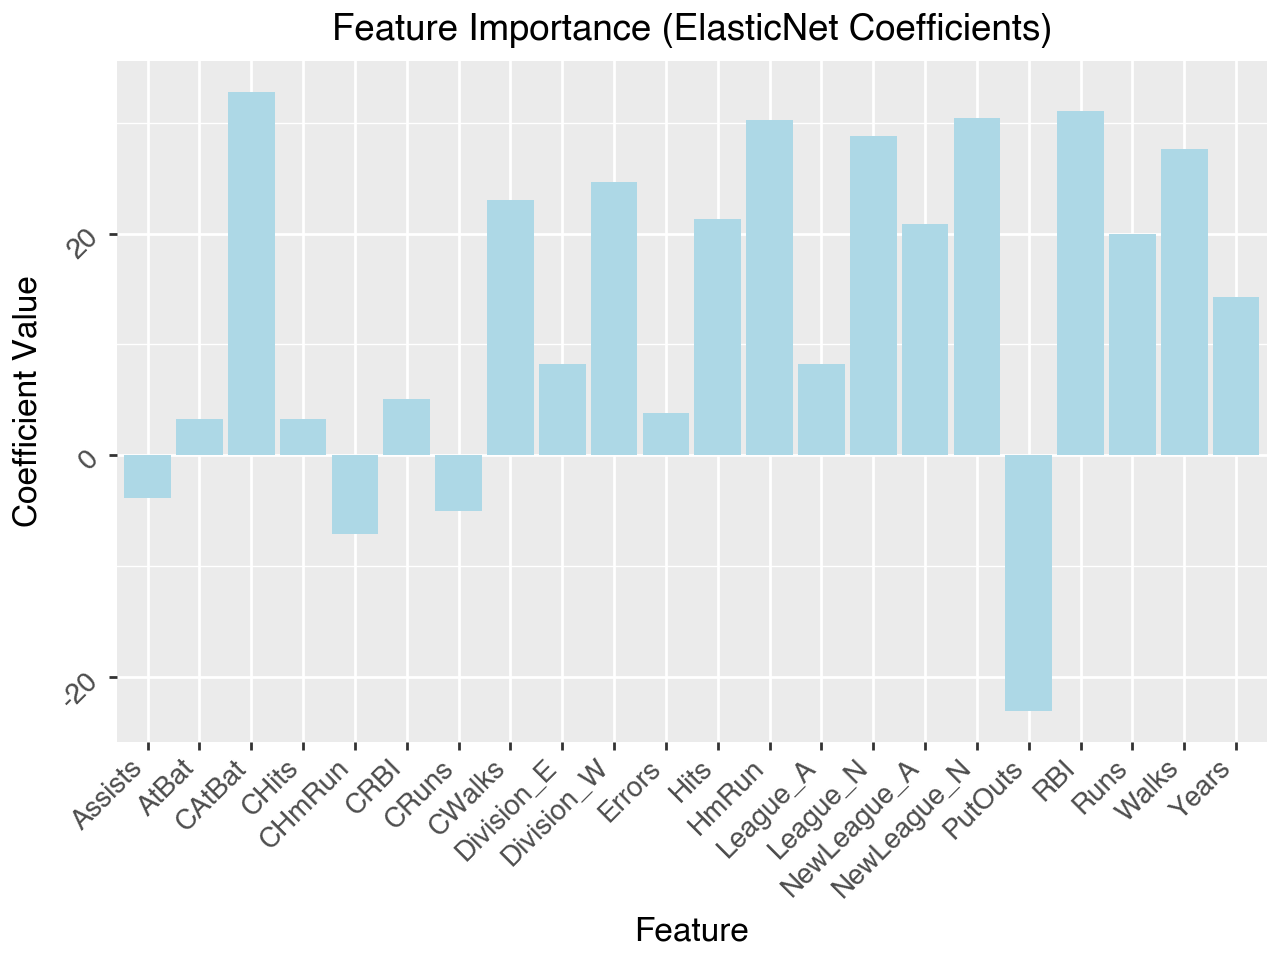

In [200]:
from plotnine import ggplot, aes, geom_bar, labs, theme, element_text
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), X.select_dtypes(include=['object']).columns)], 
    remainder='passthrough'
)

column_transformer.fit(X)
encoded_feature_names = column_transformer.transformers_[0][1].get_feature_names_out(X.select_dtypes(include=['object']).columns)
all_feature_names = list(encoded_feature_names) + [col for col in X.select_dtypes(exclude=['object']).columns]

coefficients = best_model.named_steps['regressor'].coef_

coeff_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

feature_importance_plot = (
    ggplot(coeff_df, aes(x='Feature', y='Coefficient')) +
    geom_bar(stat='identity', fill='lightblue') +
    labs(title="Feature Importance (ElasticNet Coefficients)", x="Feature", y="Coefficient Value") +
    theme(axis_title=element_text(size=12), axis_text=element_text(size=10, angle=45, hjust=1))
)

feature_importance_plot.show()

> Assists and Hits appear to be the most important features with positive coefficients.
NewLeague_A seems to have a negative impact on the prediction.

> Feature Interactions:
The model might be capturing interactions between features (e.g., AtBat and Hits) that are not explicitly shown in the plot.